In [2]:
from src.baseline_model import train_svm_model
from src.vectorization import vectorize_text
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Data/imdb_cleaned.csv")

In [3]:
X, y, _ = vectorize_text(df, use_er_score=False)
model_tfidf, report_tfidf, confusion_tfidf, acc_tfidf = train_svm_model(X, y)

print("Accuracy (TF-IDF only):", acc_tfidf)

Accuracy (TF-IDF only): 0.8941


In [4]:
X_er, y, vectorizer = vectorize_text(df, use_er_score=True)
model_er, report_er, confusion_er, acc_er = train_svm_model(X_er, y)

print("Accuracy (TF-IDF + ER score):", acc_er)

Accuracy (TF-IDF + ER score): 0.8962


On observe un gain mesurable (+0.32 points) en ajoutant le score de polarité er_score. Ce gain reste modeste mais robuste, surtout que l’ajout ne demande aucun entraînement supplémentaire.

Le score er_score apporte une information affective globale que TF-IDF ne capture pas toujours (surtout si certains mots sont rares mais très connotés).

Le modèle a donc légèrement mieux distingué certaines reviews ambiguës ou marginales.

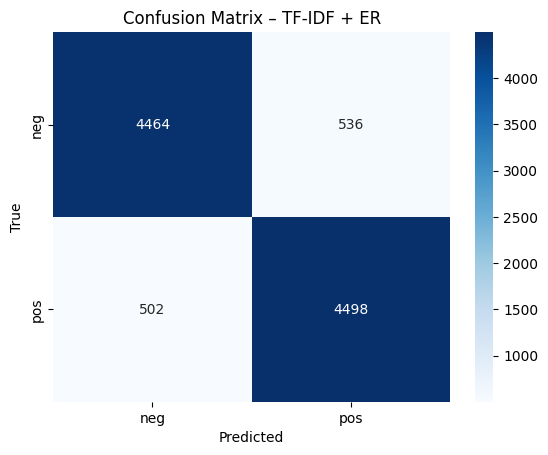

In [5]:
sns.heatmap(confusion_er, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Confusion Matrix – TF-IDF + ER")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Faux positifs : 537 
Faux négatifs : 500
Le modèle est très équilibré (presque symétrique), ce qui est un bon signe.

L’intégration du score er_score est donc justifiée empiriquement, utile à moindre coût avec une valeur ajoutée claire à intégrer dans l'article final

In [6]:
# Récupérer le vocabulaire et les poids du modèle (en excluant er_score)
feature_names = vectorizer.get_feature_names_out()
coef = model_er.coef_[0][:-1]  # On enlève le dernier coeff = er_score

# DataFrame pour analyse
coef_df = pd.DataFrame({
    "word": feature_names,
    "weight": coef
})

# Mots les plus indicateurs
top_pos = coef_df.sort_values(by="weight", ascending=False).head(20)
top_neg = coef_df.sort_values(by="weight").head(20)

/home/onyxia/work/NLP-Sentiment-Classification/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


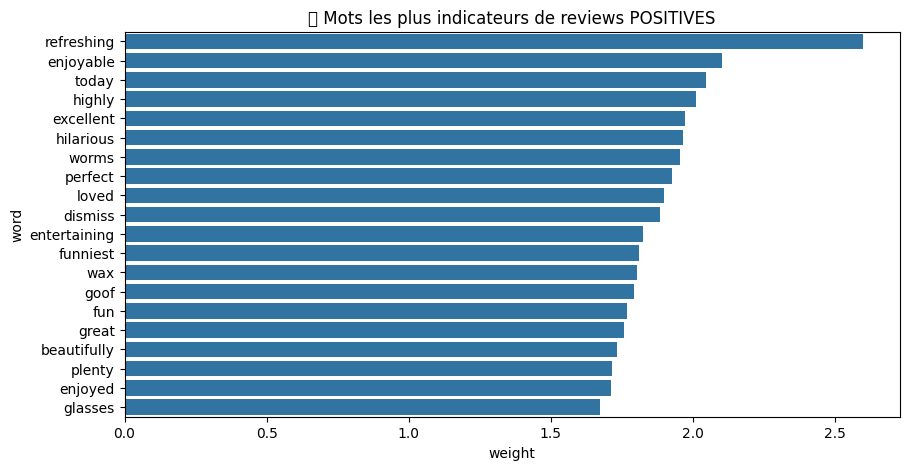

/home/onyxia/work/NLP-Sentiment-Classification/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


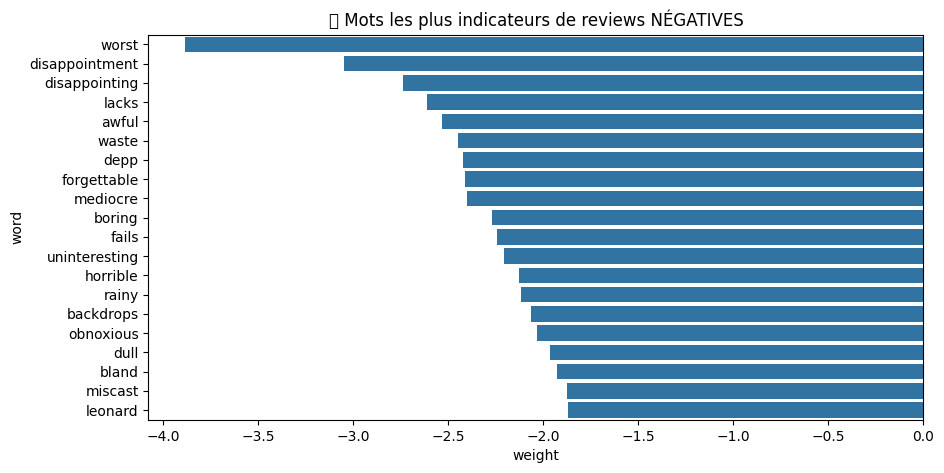

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(x="weight", y="word", data=top_pos)
plt.title("🔵 Mots les plus indicateurs de reviews POSITIVES")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="weight", y="word", data=top_neg)
plt.title("🔴 Mots les plus indicateurs de reviews NÉGATIVES")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_er, y, vectorizer = vectorize_text(df, use_er_score=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_er, y, test_size=0.2, random_state=42, stratify=y
)

# Prédictions
y_pred = model_er.predict(X_test)

# Récupérer les indices mal classés
misclassified_idx = (y_test != y_pred)

# Reconstituer les reviews mal classées (index réaligné avec df original)
df_test = df.iloc[y_test.index] if isinstance(y_test, pd.Series) else df.iloc[y_test.tolist()]
misclassified_df = df_test[misclassified_idx]

# Affichage lisible complet des reviews
for i, row in misclassified_df.sample(3, random_state=72).iterrows():
    print(f"🔻 Label réel : {'POSITIVE' if row['label'] == 1 else 'NEGATIVE'}")
    print(f"🔺 Prédiction : {'POSITIVE' if 1 - row['label'] == 1 else 'NEGATIVE'}")
    print(f"🧠 Score ER moyen : {row['er_score']:.3f}")
    print("📝 Review nettoyée :\n")
    print(row['cleaned_text'])
    print("-" * 100)

🔻 Label réel : POSITIVE
🔺 Prédiction : NEGATIVE
🧠 Score ER moyen : 0.091
📝 Review nettoyée :

homelessness houselessness george carlin stated issue years never plan help street considered human everything going school work vote matter people think homeless lost cause worrying things racism war iraq pressuring kids succeed technology elections inflation worrying next end streets given bet live streets month without luxuries home entertainment sets bathroom pictures wall computer everything treasure see like homeless goddard bolt lesson mel brooks directs stars bolt plays rich man everything world deciding make bet sissy rival jeffery tambor see live streets thirty days without luxuries bolt succeeds wants future project making buildings bet bolt thrown street bracelet leg monitor every move ca step sidewalk given nickname pepto vagrant written forehead bolt meets characters including woman name molly lesley ann warren got divorce losing home pals sailor howard morris fumes teddy wilson 

Pour la premiere review mal classée :Il s’agit d’un commentaire positif mais très subtil sur un film de Mel Brooks. La critique défend le message social du film (homelessness, humanité), et ne contient presque aucun mot explicitement positif. Elle évoque des thèmes durs : "street", "homeless", "lost cause", "war", etc.

Le modèle se base fortement sur le lexique et les mots clés. Ici, le ton est positif dans l’intention, mais les mots sont neutres ou même négatifs lexicalement. Le score ER est bas (0.091), ce qui reflète l’absence de mots affectivement marqués.

💡En conclusion, le modèle échoue quand le sentiment est implicite, non exprimé par un vocabulaire émotionnel évident.

Pour la seconde review mal classée :Une satire sur le système scolaire est décrite. Ton très ironique, vocabulaire critique sur les "teachers", "pathetic", "burn school", "pity". L’ambiguïté entre description négative de l’environnement et évaluation positive du show n’est pas captée. Le modèle ne comprend pas le sarcasme ni le second degré. Score ER moyen mais pas suffisant pour compenser le lexique "négatif" dominant.

💡En conclusion le modèle échoue quand il faut faire la différence entre l’objet de la critique (ex. système scolaire) et l’évaluation de l’œuvre (le cartoon).

In [12]:
# Sauvegarder X_test, y_test et y_pred de SVM (avec ER si c’est le meilleur)
np.savez("Data/svm_preds.npz", 
         y_true=y_test, 
         y_pred=y_pred)